In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split

In [2]:
def apply_mask(aseg_image, brain_image, labels = [2, 41]):
    from scipy.ndimage import zoom
    brain_data = brain_image.get_fdata() 
    aseg_data = aseg_image.get_fdata() 
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    segmented_brain_image = brain_data * brain_mask #applied mask on the brain image
#     resized_image = zoom(segmented_brain_image, np.array(target_size) / np.array(segmented_brain_image.shape), order=0)
    segmented_brain_image = nibabel.Nifti1Image(segmented_brain_image, affine=None) # Generating the nii image
    
    return segmented_brain_image

def resize_image(img_data):
    resized_img_data = torch.nn.functional.interpolate(
        torch.unsqueeze(torch.unsqueeze(torch.tensor(img_data), 0), 0),
        size=(100, 100, 100),
        mode='trilinear',
        align_corners=False,
    )
    return resized_img_data.squeeze().numpy()

In [3]:
csv_path = "ADNI1_Screening_1.5T_1_29_2024.csv"
# base = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg/"
mri_images = os.listdir("AD")
for i in os.listdir("CN"):
    mri_images.append(i)
for i in os.listdir("MCI"):
    mri_images.append(i)
    
csv_data = pd.read_csv(csv_path)
df = pd.DataFrame(csv_data)

In [4]:
for index, row in df.iterrows():
    file_name = row['Image Data ID'] + ".nii"
    if file_name not in mri_images:
        df = df.drop(index)
df.to_csv("filter_csv.csv")
csv_path = "filter.csv"

In [5]:
len(df), len(mri_images)

(982, 982)

In [6]:
df.head(20)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I62666,013_S_1275,MCI,F,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/22/2007,NiFTI,1/29/2024
1,I119268,121_S_1322,MCI,F,72,sc,MRI,MPR; ; N3; Scaled_2,Processed,3/02/2007,NiFTI,1/29/2024
2,I59697,116_S_0649,MCI,M,87,sc,MRI,MPR; GradWarp; N3; Scaled,Processed,7/24/2006,NiFTI,1/29/2024
3,I68581,099_S_0880,MCI,M,84,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,10/05/2006,NiFTI,1/29/2024
4,I60760,029_S_1318,MCI,F,83,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,2/17/2007,NiFTI,1/29/2024
5,I62656,013_S_1186,MCI,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,1/29/2024
6,I119369,128_S_0188,MCI,M,86,sc,MRI,MPR-R; GradWarp; N3; Scaled_2,Processed,2/06/2006,NiFTI,1/29/2024
7,I31509,023_S_0855,MCI,M,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/05/2006,NiFTI,1/29/2024
8,I63135,073_S_1357,MCI,M,71,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/09/2007,NiFTI,1/29/2024
9,I39152,130_S_0783,MCI,F,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/17/2006,NiFTI,1/29/2024


In [7]:
# Define the 3D ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Basic block for 3D ResNet
class Block(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

def resnet18():
    return ResNet(Block, [2, 2, 2, 2])

In [8]:
class MriDataset():
    def __init__(self, csv_path,transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.le = LabelEncoder()  # Add this line
        self.encoded_classes = self.le.fit_transform(self.data["Group"].values)  # Add this line

    
    def __len__(self):
        return len(self.data)

    def _load_image(self, img_id, label):
        base = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg"
        img_id = img_id + ".nii"
        subject_dir = os.path.join(label, img_id, "mri")
        
        aseg_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        brain_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        
        image = apply_mask(aseg_image, brain_image) #applying the selected labels
        image = image.get_fdata()
        
        image_resized = resize_image(image) 
        image_resized = np.expand_dims(image_resized, axis=0)
        image_resized = torch.tensor(image_resized, dtype=torch.float)
        
        return image_resized

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 1]
        label = self.data.iloc[idx, 3]
        
        img = self._load_image(img_id, label) #loading the image
        one_hot_label = np.eye(len(self.le.classes_))[self.encoded_classes[idx]]
        
        #img = np.transpose(img, (2, 0, 1))    # Transpose the image to match PyTorch's tensor format (C x H x W)
        if self.transform:
            img = self.transform(img)
        return img, one_hot_label

In [10]:
# Define transformations
transform = transforms.Compose([
#     transforms.ToTensor(),
])

dataset = MriDataset(csv_path="filter_csv.csv", transform=transform)
train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset)-(train_size + validation_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [11]:
train_size, validation_size, test_size

(687, 147, 148)

In [12]:
# Load data
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, pin_memory = True)
validation_loader = DataLoader(validation_dataset, batch_size = 20, shuffle=True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 20, shuffle=True, pin_memory = True)


#model
model = resnet18()
# model = models.resnet18(pretrained = True)

# model.conv1 = nn.Conv2d(150, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = nn.Linear(512, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
pip install torchsummary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           6,272
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [13]:
checkpoint_dir = "checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

In [16]:
from tqdm import tqdm  # Import tqdm for progress tracking

# Set the device only once and use it throughout; no need to check every time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print("CUDA can not be found, using CPU instead.")

num_epochs = 1  # number of epochs
loss_list = []  # To store loss after each epoch
accuracy_list = []  # To store accuracy after each epoch

# Move the model to the device once instead of inside the loop
model.to(device)

for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    torch.cuda.empty_cache()  # Clear CUDA cache to free memory
    
    model.train()  # Set the model to training mode
    total = 0
    correct_count = 0
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        # for batch_idx, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        # Adjust target shape if necessary (See Note below)
        if target.ndim > 1 and target.size(1) > 1:  # Case for one-hot encoded targets
            target = torch.argmax(target, dim=1)
        elif target.ndim > 1 and target.size(1) == 1:  # Case for extra singleton dimension
            target = target.squeeze()

        # Calculate accuracy
        correct = (torch.argmax(output, dim=1) == target).sum().item()
        correct_count += correct
        total += target.size(0)
    
    # Log the epoch's results
    accuracy = (correct_count / total) * 100
    loss_list.append(loss.item())
    accuracy_list.append(accuracy)
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}%")
    
    # # Save checkpoints at specified intervals
    # if (epoch + 1) % 5 == 0:stat_result = os.stat(filename)
    #     checkpoint_dir = "checkpoint_dir"  # We need to make sure this directory exists or create it
    #     if not os.path.exists(checkpoint_dir):
    #         os.makedirs(checkpoint_dir)
    #     checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    #     torch.save({
    #         'epoch': epoch + 1,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss.item(),
    #     }, checkpoint_path)
    #     print(f"Checkpoint saved to {checkpoint_path}")
    
# Save the final model
# torch.save(model.state_dict(), "model_final.pt")
print("Final model saved.")

CUDA can not be found, using CPU instead.


Epochs:   0%|                                                                                 | 0/1 [00:00<?, ?epoch/s]
Epoch 1: 0batch [00:00, ?batch/s]
Epoch 1: 1batch [00:27, 27.61s/batch]
Epoch 1: 2batch [00:54, 27.13s/batch]
Epoch 1: 3batch [01:20, 26.53s/batch]
Epoch 1: 4batch [01:45, 26.11s/batch]
Epoch 1: 5batch [02:11, 26.10s/batch]
Epoch 1: 6batch [02:36, 25.78s/batch]
Epoch 1: 7batch [03:02, 25.71s/batch]
Epoch 1: 8batch [03:28, 25.89s/batch]
Epoch 1: 9batch [03:56, 26.34s/batch]
Epoch 1: 10batch [04:22, 26.28s/batch]
Epoch 1: 11batch [04:48, 26.16s/batch]
Epoch 1: 12batch [05:13, 26.06s/batch]
Epoch 1: 13batch [05:40, 26.19s/batch]
Epoch 1: 14batch [06:06, 26.27s/batch]
Epoch 1: 15batch [06:32, 26.06s/batch]
Epoch 1: 16batch [06:58, 25.97s/batch]
Epoch 1: 17batch [07:23, 25.66s/batch]
Epoch 1: 18batch [07:49, 25.71s/batch]
Epoch 1: 19batch [08:14, 25.66s/batch]
Epoch 1: 20batch [08:41, 25.91s/batch]
Epoch 1: 21batch [09:07, 25.97s/batch]
Epoch 1: 22batch [09:33, 25.98s/batc

Epoch: 1/1, Loss: 1.0130, Accuracy: 42.9403%
Final model saved.


Text(0.5, 1.0, 'Training Accuracy')

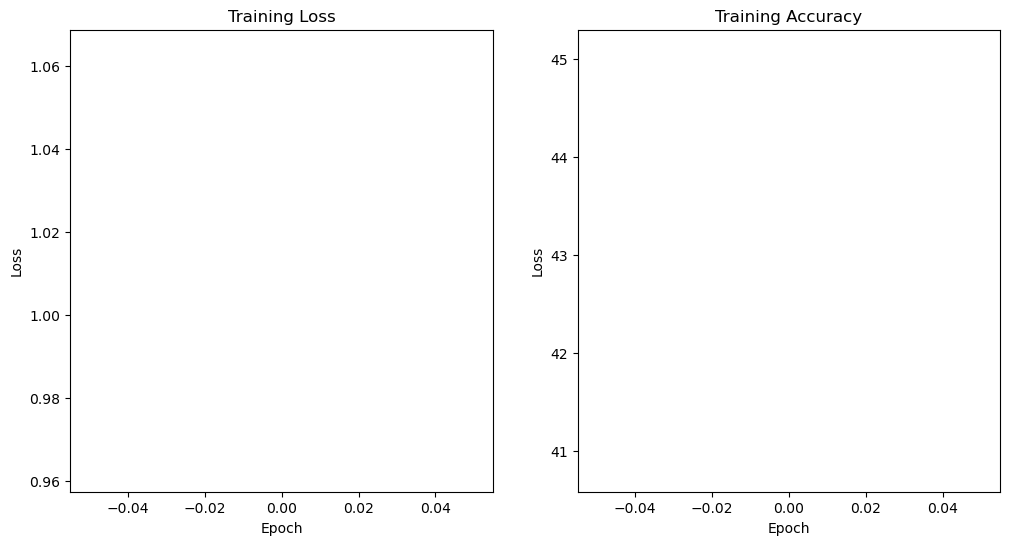

In [17]:
_, (loss_graph, accuracy_graph) = plt.subplots(1, 2, figsize=(12,6))

loss_graph.plot(loss_list)
loss_graph.set_xlabel("Epoch")
loss_graph.set_ylabel("Loss")
loss_graph.set_title("Training Loss")

accuracy_graph.plot(accuracy_list)
accuracy_graph.set_xlabel("Epoch")
accuracy_graph.set_ylabel("Loss")
accuracy_graph.set_title("Training Accuracy")

In [18]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, target in validation_loader:
        model = model.to(device)
        data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)
        output = model(data)
        output = output.cpu()
        target = target.cpu()
        
        all_preds.extend(torch.argmax(output, dim = 1))
        all_labels.extend(torch.argmax(target, dim=1))


accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

C:\Users\simra\AppData\Local\Temp\ipykernel_10616\318942741.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)


Validation accuracy: 47.62%


In [28]:
given the following data:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for data, target in test_loader:
        model = model.to(device)
        data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)
        output = model(data)
        output = output.cpu()
        target = target.cpu()
        
        test_preds.extend(torch.argmax(output, dim = 1))
        test_labels.extend(torch.argmax(target, dim=1))


accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

FileNotFoundError: No such file or no access: 'MCI/I34837.nii/mri/aparc.DKTatlas+aseg.deep.mgz'

In [22]:
from sklearn.metrics import precision_score, f1_score, roc_auc_score, accuracy_score

model.eval()
test_preds = []
test_labels = []

# Ensure evaluation without gradient calculation
with torch.no_grad():
    for data, target in test_loader:
        # Move data and model to device
        model = model.to(device)
        data, target = data.to(device, dtype=torch.float), target.to(device)
        
        # Forward pass
        output = model(data)
        
        # Collect predictions and true labels
        test_preds.extend(torch.argmax(output.cpu(), dim=1).numpy())
        test_labels.extend(torch.argmax(target.cpu(), dim=1).numpy())

# Compute accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Compute precision
precision = precision_score(test_labels, test_preds, average='weighted')  # 'weighted' for multi-class tasks
print(f"Precision: {precision:.2f}")

# Compute F1 score
f1 = f1_score(test_labels, test_preds, average='weighted')  # Adjust 'average' as needed
print(f"F1 Score: {f1:.2f}")

# Compute AUC-ROC
# For multi-class problems, provide one-hot encoding of test_labels and test_preds probabilities
if len(set(test_labels)) > 2:  # Check if multi-class
    test_labels_one_hot = np.eye(len(set(test_labels)))[test_labels]  # One-hot encoding
    output_probs = torch.nn.functional.softmax(output.cpu(), dim=1).numpy()
    auc_roc = roc_auc_score(test_labels_one_hot, output_probs, multi_class="ovr")
else:
    output_probs = torch.nn.functional.softmax(output.cpu(), dim=1)[:, 1].numpy()
    auc_roc = roc_auc_score(test_labels, output_probs)

print(f"AUC-ROC: {auc_roc:.2f}")


Test accuracy: 52.70%
Precision: 0.28
F1 Score: 0.36


C:\Users\simra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Found input variables with inconsistent numbers of samples: [148, 8]

In [23]:
# Compute AUC-ROC
if len(set(test_labels)) > 2:  # Multi-class case
    test_labels_one_hot = np.eye(len(set(test_labels)))[test_labels]  # One-hot encoding
    auc_roc = roc_auc_score(test_labels_one_hot, np.array(all_probs), multi_class="ovr")
else:  # Binary classification case
    auc_roc = roc_auc_score(test_labels, np.array(all_probs)[:, 1])  # Use positive class probabilities

print(f"AUC-ROC: {auc_roc:.2f}")

NameError: name 'all_probs' is not defined

In [ ]:
from torchvision.models import resnet18
import torch
from torchsummary import summary
import torch.nn as nn

# Load and modify the model
model = resnet18()
model.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for 2 input channels

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Display the summary
summary(model, input_size=(2, 224, 224))  # Adjust input size to match your data